In [1]:
from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'MALRQKDQGNT'
jobname = 'test'
num_relax = 0
template_mode = "none"

use_amber = num_relax > 0

query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

os.makedirs(jobname, exist_ok=True)

queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False




In [2]:

import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Mambaforge-Linux-x86_64.sh")
    os.system("bash Mambaforge-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    os.system(f"mamba install -y -c conda-forge openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

In [3]:
msa_mode = "mmseqs2_uniref_env"
pair_mode = "unpaired_paired"

if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [4]:
model_type = "auto"
num_recycles = "3"
recycle_early_stop_tolerance = "auto"
relax_max_iterations = 200
pairing_strategy = "greedy"

max_msa = "auto"
num_seeds = 1
use_dropout = False

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

save_all = False
save_recycles = False
save_to_google_drive = False
dpi = 200

if save_to_google_drive:
  from pydrive2.drive import GoogleDrive
  from pydrive2.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)



2024-02-25 20:00:43,965 Running on GPU
2024-02-25 20:00:44,157 Found 5 citations for tools or databases
2024-02-25 20:00:44,158 Query 1/1: test_37482 (length 11)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:01 remaining: 00:00]


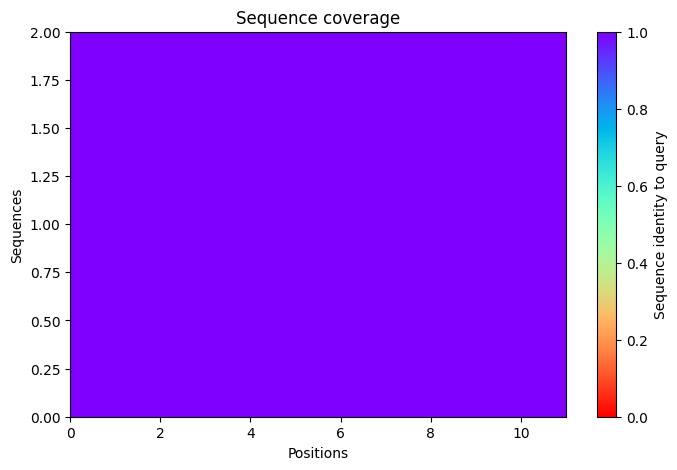

2024-02-25 20:00:46,166 Setting max_seq=2, max_extra_seq=1
2024-02-25 20:01:26,519 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=68.1 pTM=0.0381
2024-02-25 20:01:26,619 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=68 pTM=0.0375 tol=0.391
2024-02-25 20:01:26,717 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=71.2 pTM=0.0385 tol=0.464
2024-02-25 20:01:26,804 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=67.4 pTM=0.0374 tol=0.64
2024-02-25 20:01:26,806 alphafold2_ptm_model_1_seed_000 took 27.3s (3 recycles)


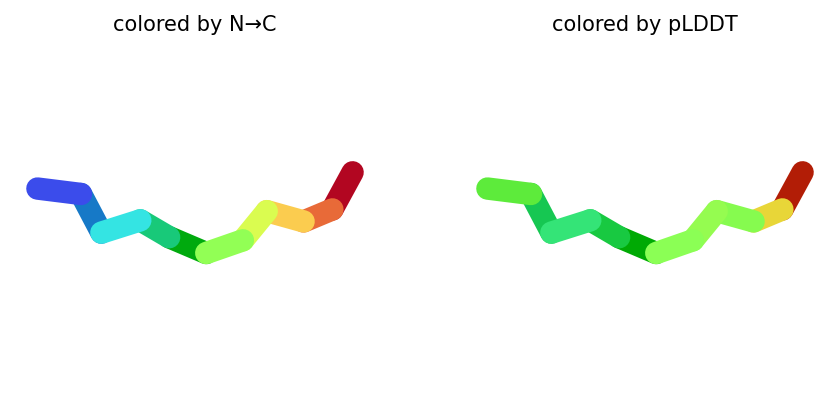

2024-02-25 20:01:27,025 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=69.5 pTM=0.0368
2024-02-25 20:01:27,110 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=69.6 pTM=0.0368 tol=0.548
2024-02-25 20:01:27,196 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=70.6 pTM=0.0374 tol=0.34
2024-02-25 20:01:27,282 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=69.4 pTM=0.0367 tol=0.182
2024-02-25 20:01:27,283 alphafold2_ptm_model_2_seed_000 took 0.4s (3 recycles)


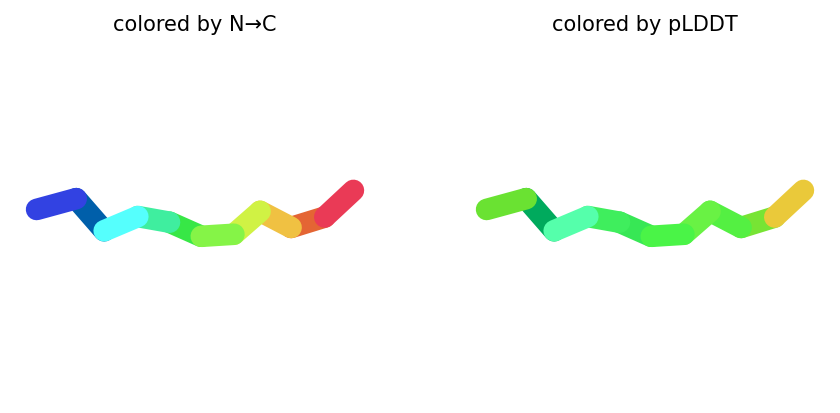

2024-02-25 20:01:27,459 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=69.9 pTM=0.0362
2024-02-25 20:01:27,545 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=71.4 pTM=0.0362 tol=0.358
2024-02-25 20:01:27,631 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=72.2 pTM=0.0361 tol=0.269
2024-02-25 20:01:27,717 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=72.4 pTM=0.0358 tol=0.122
2024-02-25 20:01:27,718 alphafold2_ptm_model_3_seed_000 took 0.3s (3 recycles)


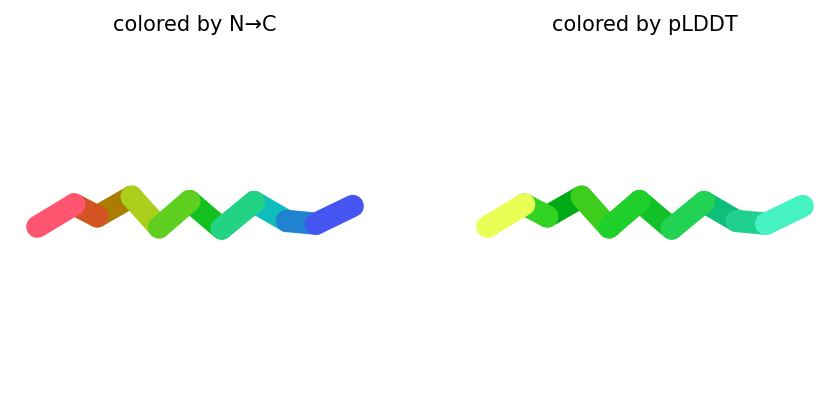

2024-02-25 20:01:27,902 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=74.3 pTM=0.037
2024-02-25 20:01:27,987 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=74.2 pTM=0.0369 tol=0.171
2024-02-25 20:01:28,072 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=72.9 pTM=0.0371 tol=0.107
2024-02-25 20:01:28,158 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=73.8 pTM=0.037 tol=0.129
2024-02-25 20:01:28,160 alphafold2_ptm_model_4_seed_000 took 0.3s (3 recycles)


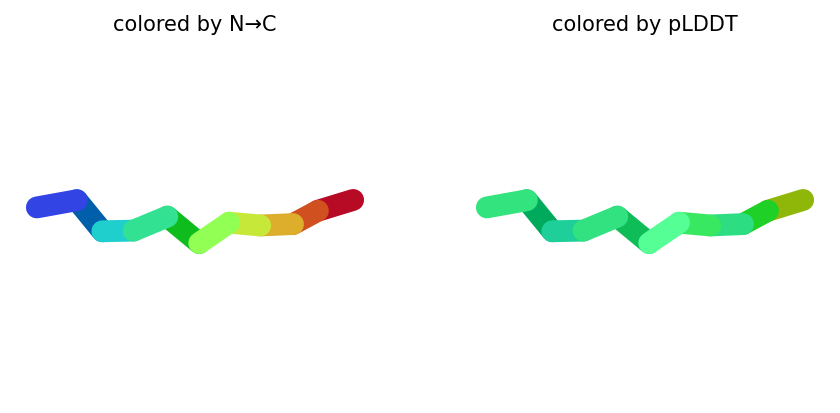

2024-02-25 20:01:28,342 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=70.4 pTM=0.0377
2024-02-25 20:01:28,428 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=70.4 pTM=0.0377 tol=0.273
2024-02-25 20:01:28,514 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=72.3 pTM=0.0378 tol=0.304
2024-02-25 20:01:28,600 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=71.6 pTM=0.0374 tol=0.18
2024-02-25 20:01:28,601 alphafold2_ptm_model_5_seed_000 took 0.3s (3 recycles)


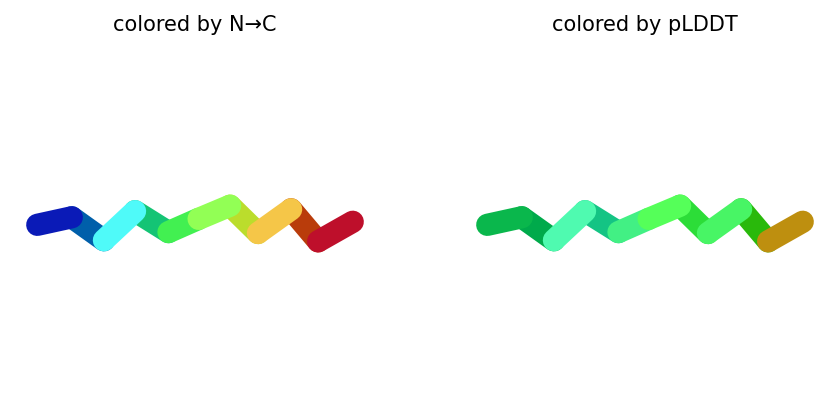

2024-02-25 20:01:28,689 reranking models by 'plddt' metric
2024-02-25 20:01:28,689 rank_001_alphafold2_ptm_model_4_seed_000 pLDDT=73.8 pTM=0.037
2024-02-25 20:01:28,690 rank_002_alphafold2_ptm_model_3_seed_000 pLDDT=72.4 pTM=0.0358
2024-02-25 20:01:28,690 rank_003_alphafold2_ptm_model_5_seed_000 pLDDT=71.6 pTM=0.0374
2024-02-25 20:01:28,690 rank_004_alphafold2_ptm_model_2_seed_000 pLDDT=69.4 pTM=0.0367
2024-02-25 20:01:28,691 rank_005_alphafold2_ptm_model_1_seed_000 pLDDT=67.4 pTM=0.0374
2024-02-25 20:01:30,452 Done


0

In [5]:
display_images = True

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

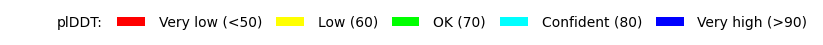

In [6]:
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 1
color = "lDDT"
show_sidechains = False
show_mainchains = False

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()


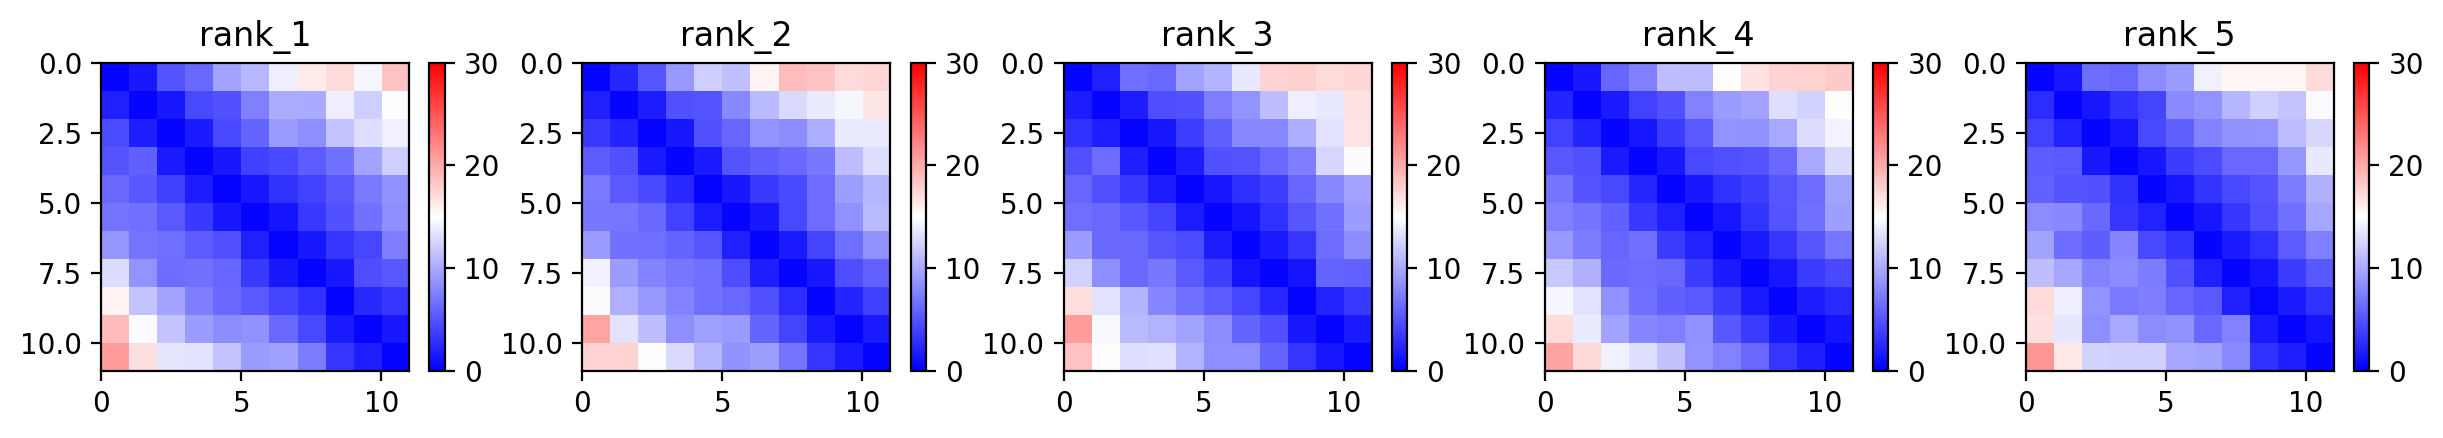
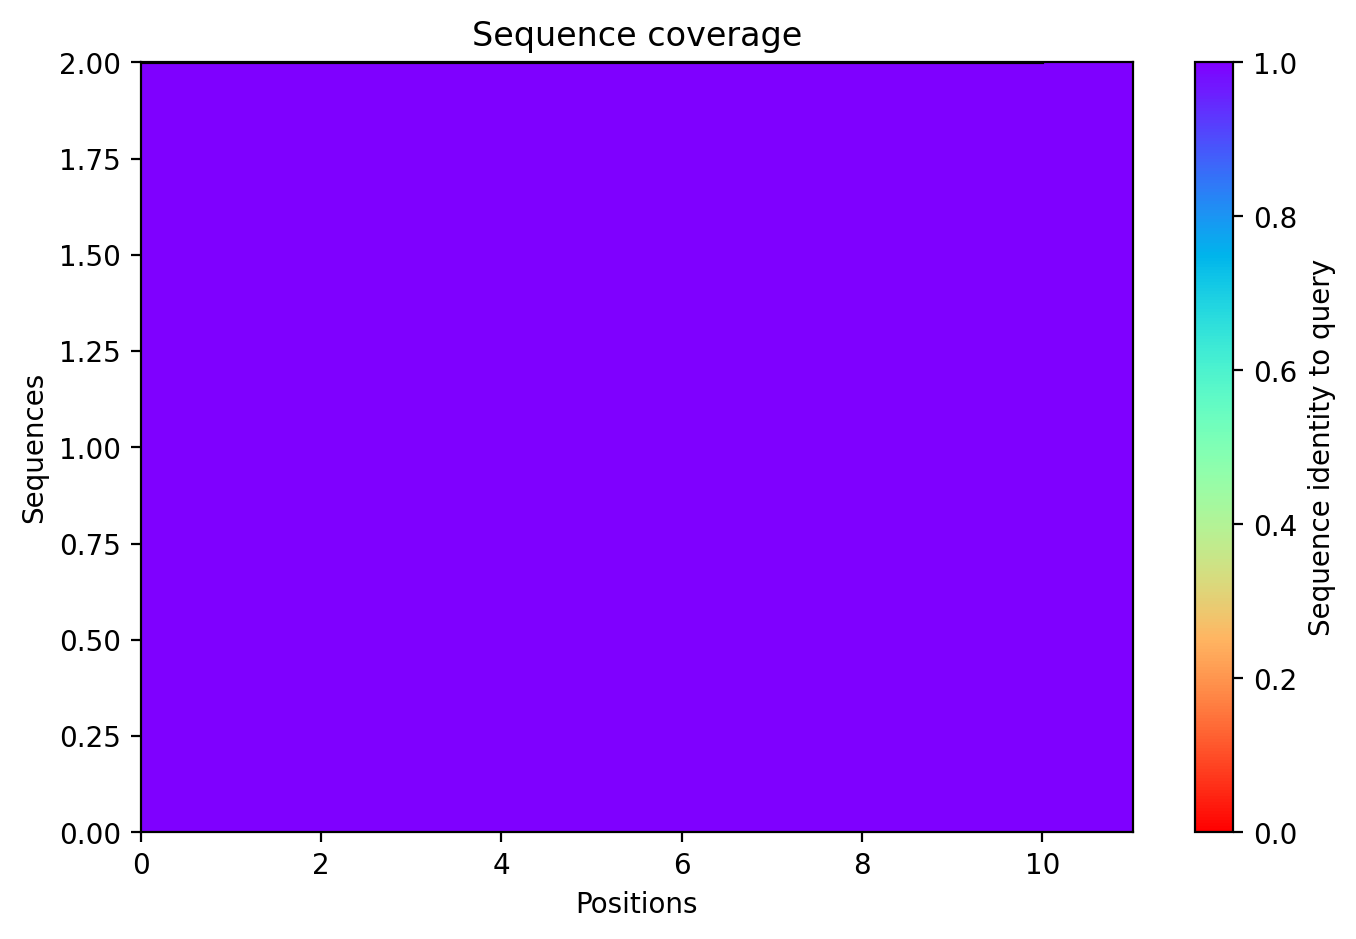
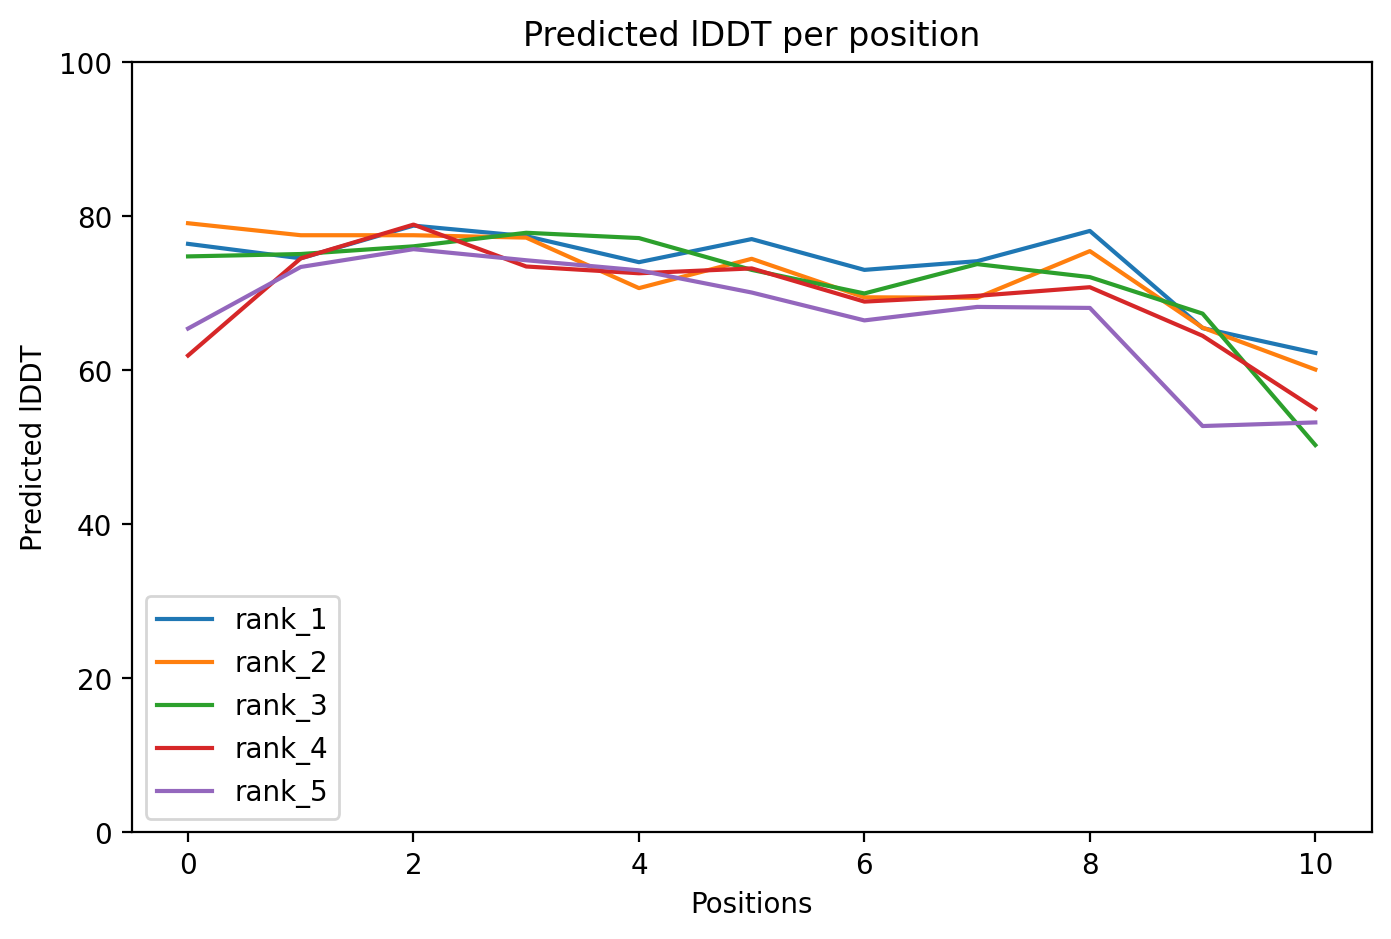

In [8]:
from IPython.display import display, HTML
import base64
from html import escape

def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = ""
pae_file = os.path.join(jobname,f"{jobname}{jobname_prefix}_pae.png")
if os.path.isfile(pae_file):
    pae = image_to_data_url(pae_file)
cov = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_coverage.png"))
plddt = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_plddt.png"))
display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  { '<!--' if pae == '' else '' }<img src="{pae}" class="full" />{ '-->' if pae == '' else '' }
  <img src="{cov}" class="half" />
  <img src="{plddt}" class="half" />
</div>
"""))
